<a href="https://colab.research.google.com/github/SheshamJoseph/malaria_detection/blob/main/malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malaria Detection

## Preprocess the data

### Fetching the data

In [1]:
!wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip

--2025-08-03 13:38:36--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.163.189.83, 3.163.189.81, 3.163.189.93, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.163.189.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  56.5MB/s    in 6.4s    

2025-08-03 13:38:43 (52.3 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [2]:
# unzip the files
import zipfile
zip_ref = zipfile.ZipFile('/content/cell_images.zip')
zip_ref.extractall()
zip_ref.close()

In [3]:
# Perform OS walk through directory and list number of files
import os

for dirpath, dirnames, filenames in os.walk('/content/cell_images'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in /content/cell_images
There are 0 directories and 13780 images in /content/cell_images/Uninfected
There are 0 directories and 13780 images in /content/cell_images/Parasitized


###  Visualize images

In [4]:
# setting class names
import pathlib
import numpy as np

data_dir = pathlib.Path('/content/cell_images')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Parasitized' 'Uninfected']


In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # setup the target directory
    target_folder = target_dir + target_class

    # get random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    # read and plot image
    img = mpimg.imread(target_folder + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')

    # print image shape
    print(f'Image shape: {img.shape}')

    return img

Image shape: (139, 118, 3)


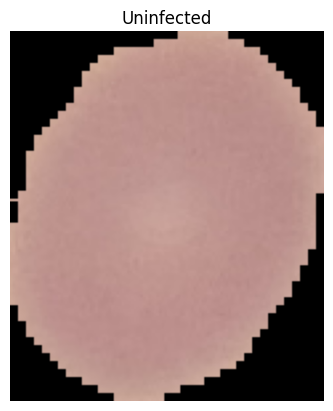

In [6]:
# view random image
target_class = random.choice(class_names)
img = view_random_image(target_dir='/content/cell_images/', target_class=target_class)

In [7]:
img

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

### Loading and preparing dataset

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

IMAGE_SIZE = (224, 224)  # Suitable for ResNet50, VGG16, etc.
BATCH_SIZE = 32

# Path to your dataset folder
DATASET_DIR = 'cell_images/'

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load training data
train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


## Model building

### Creating callbacks

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

### Squeezenet model

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def fire_module(x, squeeze_filters, expand_filters):
    # Squeeze layer
    squeeze = layers.Conv2D(squeeze_filters, (1, 1), activation='relu', padding='same')(x)

    # Expand layers
    expand_1x1 = layers.Conv2D(expand_filters, (1, 1), activation='relu', padding='same')(squeeze)
    expand_3x3 = layers.Conv2D(expand_filters, (3, 3), activation='relu', padding='same')(squeeze)

    # Concatenate expand layers
    output = layers.concatenate([expand_1x1, expand_3x3], axis=-1)
    return output

def squeezenet_base(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(96, (7, 7), strides=(2, 2), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    # Add fire modules
    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire_module(x, 64, 256)

    return input_layer, x

In [ ]:
# build model

IMAGE_SHAPE = (224, 224, 3)

input_layer, x = squeezenet_base(IMAGE_SHAPE)
x =